In [1]:
%%capture
!{sys.executable} -m pip install openai
!{sys.executable} -m pip install litellm

In [2]:
import os, sys
from openai import OpenAI

if not os.environ["OPENAI_API_KEY"]: 
    os.environ["OPENAI_API_KEY"]= '<REDACTED>'

MODEL = "gpt-4o-mini"

client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),
)

Baseline decision tree:

In [1]:
class Node:
    def __init__(self, question=None, tag = None, yes_branch=None, no_branch=None, examples=None, summary=None):
        self.question = question
        self.yes_branch = yes_branch
        self.no_branch = no_branch
        self.examples = examples
        self.summary = summary
        self.tag = tag

def print_tree(node, indent=0):
    """ Recursively print the decision tree. """
    if node is None:
        return
    if node.summary:
        # Print leaf node summary
        print(' ' * indent + f'→ Summary: The keyword is {node.summary}.')
    if node.examples:
        # Print leaf node examples
        print(' ' * indent + f'→ Examples: {", ".join(node.examples)}')
    if node.question:
        # Print the question node
        turn = indent // 4 + 1
        print(' ' * indent + f'Turn {turn}: {node.question}')
        if node.yes_branch or node.no_branch:
            print(' ' * indent + ' ├─ Yes:')
            print_tree(node.yes_branch, indent + 4)  # Print yes branch
            print(' ' * indent + ' └─ No:')
            print_tree(node.no_branch, indent + 4)   # Print no branch

# Define the decision tree structure
tree = Node(
    "Is it a place?",
    tag = "place",
    yes_branch=Node(
        examples=['Lesotho', 'Acapulco', 'Oceania', 'Parking lot'],
        question="Is it a country?",
        tag = "country",
        yes_branch=Node(
            examples=['Brazil', 'Japan', 'Kenya', 'Norway'],
            question="Is this country either in Asia or in Africa?",
            yes_branch=Node(
                examples=['Thailand', 'North Korea', 'Egypt', 'Nigeria'],
                question="Is this country in Asia?",
                yes_branch=Node(summary='a country in Asia', examples=['Kazakhstan', 'South Korea']),
                no_branch=Node(summary='a country in Africa', examples=['Morocco', 'Ghana'])
            ),
            no_branch=Node(
                examples=['Lithuania', 'Papua New Guinea', 'Uruguay', 'Slovakia'],
                question="Is this country in Europe?",
                yes_branch=Node(summary='a country in Europe', examples=['Romania', 'Germany']),
                no_branch=Node(
                    examples=['Australia', 'Nicaragua', 'Chile', 'United States'],
                    question="Is this country in the Americas?",
                    yes_branch=Node(summary='a country in the Americas', examples=['Argentina', 'Canada']),
                    no_branch=Node(summary='a country in Oceania', examples=['New Zealand', 'Samoa'])
                )
            )
        ),
        no_branch=Node(
            examples=['Venice', 'Lagos', 'Times Square', 'Colosseum'],
            question="Is it a city?",
            tag = "city",
            yes_branch=Node(
                examples=['Paris', 'Astana', 'Alexandria', 'Sao Paulo'],
                question="Is it a capital city?",
                yes_branch=Node(summary='a capital city', examples=['Moscow', 'Santiago']),
                no_branch=Node(summary='a city which is not a capital', examples=['Chicago', 'Tianjin'])
            ),
            no_branch=Node(
                examples=['Oceania', 'Nevada', 'Times Square', 'Colosseum'],
                question="Is it either a continent or a state of a country?",
                yes_branch=Node(
                    examples=['North America', 'Nevada', 'Roraima', 'Uttar Pradesh'],
                    question="Is it a continent?",
                    yes_branch=Node(summary='a continent', examples=['Africa', 'Asia']),
                    no_branch=Node(summary='a state of a country', examples=['Kentucky', 'Santa Catarina Brazil'])
                ),
                no_branch=Node(
                    examples=['Copacabana beach', 'university campus', 'Antarctica', 'tundra'],
                    question="Is it a location made by humans?",
                    yes_branch=Node(summary='a location made by humans', examples=['Champs-Elysees', 'Amusement park']),
                    no_branch=Node(summary='a natural location', examples=['Amazon rainforest', 'Desert'])
                )
            )
        )
    ),
    no_branch=Node(
        examples=['Pencil sharpener', 'cloud', 'chimney', 'electric vehicle'],
        question="Is it man-made?",
        tag="man-made",
        yes_branch=Node(
            examples=['plastic bottle', 'martini', 'earbuds', 'helicopter'],
            question="Is it found indoors?",
            tag="indoors",
            yes_branch=Node(
                examples=['pencil sharpener', 'refrigerator', 'coffee machine', 'escalator'],
                question="Is it something found in a home?",
                tag="home",
                yes_branch=Node(summary='a man-made thing found in people\'s homes', examples=["Bed frame", "Stove"]),
                no_branch=Node(summary='a man-made thing found indoors but not in people\'s homes', examples=["Hospital bed", "Erlenmeyer flask"])
            ),
            no_branch=Node(
                examples=['pickup truck', 'train', 'fountain', 'obelisk'],
                question="Is it something found in a city?",
                tag="city",
                yes_branch=Node(summary='a man-made thing found outdoors in cities', examples=['Apartment Building', 'Fire Hydrant']),
                no_branch=Node(summary='a man-made thing found outdoors outside of cities', examples=['Satellite', 'Barn'])
            ),
        ),
        no_branch=Node(
            examples=['thunder', 'Acacia', 'giraffe', 'river'],
            question="Is it a living thing?",
            tag="living",
            yes_branch=Node(
                examples=['Palm tree', 'beetle', 'whale', 'apple'],
                question="Is it an animal?",
                tag="animal",
                yes_branch=Node(
                    examples=['sea lion', 'cape toad', 'kangaroo', 'peacock'],
                    question="Is it a mammal or a bird?",
                    yes_branch=Node(summary='either a mammal or a bird', examples=["Elephant", "Seagull"]),
                    no_branch=Node(summary='either a fish, insect, reptilian or amphibian', examples=["Shark", "Wasp", "Frog", "Alligator"])
                ),
                no_branch=Node(
                    examples=['mold', 'deciduous tree', 'yeast', 'agave'],
                    question="Is it a plant?",
                    tag="plant",
                    yes_branch=Node(
                        examples=['orchid', 'poison ivy', 'maple tree', 'sunflower'],
                        question="Is it a tree?",
                        yes_branch=Node(summary='a tree', examples=["Oak tree", "Cactus"]),
                        no_branch=Node(summary='a plant which is not a tree', examples=["Rose", "Fern"])
                    ),
                    no_branch=Node(
                        examples=['black mold', 'truffle', 'cremini mushroom', 'bacillus'],
                        question="Is it a fungus?",
                        yes_branch=Node(summary='a fungus', examples=["Wood ear mushroom", "Yeast"]),
                        no_branch=Node(summary='a bacteria', examples=['E Coli', 'Streptococcus'])
                    )
                )
            ),
            no_branch=Node(
                examples=['uranus', 'seine river', 'carbon', 'electron'],
                question="Is it a geological feature?",
                tag="geological feature",
                yes_branch=Node(
                    examples=['Mount Fuji', 'volcano', 'canyon', 'Rocky mountains'],
                    question="Is it a body of water?",
                    yes_branch=Node(summary='a body of water', examples=["River", "Mediterranean Sea"]),
                    no_branch=Node(summary='a geological feature which is not a body of water', examples=["Cave", "Volcano"])
                ),
                no_branch=Node(
                    examples=['mercury', 'sun', 'iron', 'lead'],
                    question="Is it a chemical element, molecule or compound?",
                    yes_branch=Node(summary='a chemical element, molecule or compound', examples=["Salt", "Oxygen"]),
                    no_branch=Node(summary='a non-living thing not made by humans', examples=['Pebble', 'Milky Way'])
                )
            )
        )
    )
)

# Print the decision tree
print_tree(tree)

Turn 1: Is it a place?
 ├─ Yes:
    → Examples: Lesotho, Acapulco, Oceania, Parking lot
    Turn 2: Is it a country?
     ├─ Yes:
        → Examples: Brazil, Japan, Kenya, Norway
        Turn 3: Is this country either in Asia or in Africa?
         ├─ Yes:
            → Examples: Thailand, North Korea, Egypt, Nigeria
            Turn 4: Is this country in Asia?
             ├─ Yes:
                → Summary: The keyword is a country in Asia.
                → Examples: Kazakhstan, South Korea
             └─ No:
                → Summary: The keyword is a country in Africa.
                → Examples: Morocco, Ghana
         └─ No:
            → Examples: Lithuania, Papua New Guinea, Uruguay, Slovakia
            Turn 4: Is this country in Europe?
             ├─ Yes:
                → Summary: The keyword is a country in Europe.
                → Examples: Romania, Germany
             └─ No:
                → Examples: Australia, Nicaragua, Chile, United States
                Turn 5

Open keywords data:

In [2]:
def read_file_to_list(file_path):
    with open(file_path, 'r') as file:
        lines = file.read().splitlines()
    return lines

keywords_list = read_file_to_list('20qs-data/keywords.txt')
keywords_list = keywords_list[1:]
print(f"Number of keywords in data: {len(keywords_list)}")

Number of keywords in data: 2046


## Label Data

In [15]:
from collections import Counter
from tqdm import tqdm
import time

def get_answer_from_node(node, keyword):
    
    prompt = f"Keyword: {keyword}\n\nQuestion: {node.question}\n\n"
    prompt += "\nPlease provide an answer to the question based on the keyword. ONLY ANSWER Yes OR No. IF UNSURE, CHOOSE MOST LIKELY ANSWER FROM Yes OR No. "
    
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "user", "content": prompt}
        ],
        max_tokens=10
    )
    response = response.choices[0].message.content

    return response


def label_keywords(node, keywords, labels, results):
    
    question_tag = node.tag
    yes_no_counts = Counter()

    for keyword in tqdm(keywords, desc = 'label_keywords', position = 0, leave = True, ncols = 100):
        answer = get_answer_from_node(node, keyword)
        answer = answer.lower()
        # Count yes/no answers
        if 'yes' in answer:
            yes_no_counts['yes'] += 1
            answer = 'yes'
        elif 'no' in answer:
            yes_no_counts['no'] += 1
            answer = 'no'
        else:
            yes_no_counts['err'] +=1
            answer = 'err'
        if keyword in labels:
            labels[keyword][question_tag] = answer
        else:
            labels[keyword] = {question_tag: answer}

    # Calculate percentages
    total_answers = sum(yes_no_counts.values())
    yes_percentage = (yes_no_counts['yes'] / total_answers) * 100 if total_answers > 0 else 0
    no_percentage = (yes_no_counts['no'] / total_answers) * 100 if total_answers > 0 else 0
    err_percentage = (yes_no_counts['err'] / total_answers) * 100 if total_answers > 0 else 0

    # Print results
    print(node.question)
    print(f"Yes answers: {yes_no_counts['yes']}, percentage: {yes_percentage:.2f}%")
    print(f"No answers: {yes_no_counts['no']}, percentage: {no_percentage:.2f}%")
    print(f"Error answers: {yes_no_counts['err']}, percentage: {err_percentage:.2f}%")

    # Save results
    results[question_tag] = {
        'yes_percentage': yes_percentage,
        'no_percentage': no_percentage,
        'value_counts': dict(yes_no_counts)
    }

    return labels, results

Read current keyword labels and results:

In [3]:
import json

def read_jsonl_and_transform(file_path):
    result_dict = {}

    with open(file_path, 'r') as file:
        for line in file:
            record = json.loads(line)
            keyword = record.pop('keyword')
            result_dict[keyword] = record

    return result_dict

def read_json_to_dict(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

keyword_labels, results = read_jsonl_and_transform('20qs-data/labeled_keywords.jsonl'), read_json_to_dict('20qs-data/labeling_results.jsonl')

Label places/things:

In [72]:
keyword_labels, results = label_keywords(tree, keywords_list, keyword_labels, results)

Is it a place?
Yes answers: 719, percentage: 35.15892420537897%
No answers: 1326, percentage: 64.84107579462103%
Error answers: 0, percentage: 0.0%


In [4]:
keyword_places = [keyword for keyword in keywords_list if keyword_labels[keyword]['place'] == 'yes']
keyword_things = [keyword for keyword in keywords_list if keyword_labels[keyword]['place'] == 'no']
things_branch = tree.no_branch
places_branch = tree.yes_branch

print(f"Number of keywords labeled as things: {len(keyword_things)}.")

Number of keywords labeled as things: 1327.


Label man-made living:

In [100]:
keyword_labels, results = label_keywords(not_man_made_branch, keyword_not_man_made, keyword_labels, results)

Is it a living thing?
Yes answers: 182, percentage: 64.31095406360424%
No answers: 101, percentage: 35.68904593639576%
Error answers: 0, percentage: 0.0%


In [104]:
living_branch = not_man_made_branch.yes_branch
not_living_branch = not_man_made_branch.no_branch

Label indoors:

In [110]:
keyword_labels, results = label_keywords(man_made_branch, keyword_man_made, keyword_labels, results)

Is it found indoors?
Yes answers: 912, percentage: 87.44%
No answers: 131, percentage: 12.56%
Error answers: 0, percentage: 0.00%


In [111]:
keyword_indoors = [keyword for keyword in keyword_man_made if keyword_labels[keyword]['indoors'] == 'yes']
keyword_outdoors = [keyword for keyword in keyword_man_made if keyword_labels[keyword]['indoors'] == 'no']

Categorical labels:

In [10]:
category_nodes = [
    Node(question='Is it broadly related to food, drinks or cooking?', tag='food, drinks, cooking'),
    Node(question='Is it broadly related to arts, sports or entertainment?', tag='arts, sports, entertainment'),
    Node(question='Is it broadly related to clothing, beauty or accessories?', tag='clothing, beauty, accessories'),
    Node(question='Is it broadly related to furniture or architecture?', tag='furniture, architecture'),
    Node(question='Is it broadly related to cleaning or hygiene?', tag='cleaning, hygiene'),
    Node(question='Is it broadly related to transportation or vehicles?', tag='transportation, vehicles'),
    Node(question='Is it broadly related to electronics or technology?', tag='electronics, technology'),    
    Node(question='Is it broadly related to agriculture or industry?', tag='agriculture, industry'),
    Node(question='Is it related to science or education?', tag='science, school, education'),
    Node(question='Is it related to health or safety?', tag='health, safety'),
]

In [ ]:
for cat_node in tqdm(category_nodes, desc = 'categories', ncols=150):
    keyword_labels, results = label_keywords(cat_node, keyword_things, keyword_labels, results)

In [11]:
keyword_labels, results = label_keywords(category_nodes[-2], keyword_things, keyword_labels, results)

label_keywords: 100%|███████████████████████████████████████████| 1327/1327 [11:24<00:00,  1.94it/s]

Is it related to science or education?
Yes answers: 470, percentage: 35.42%
No answers: 857, percentage: 64.58%
Error answers: 0, percentage: 0.00%


In [13]:
living_branch = tree.no_branch.no_branch
indoors_branch = tree.no_branch.yes_branch
print(living_branch.question, living_branch.tag)
print(indoors_branch.question, indoors_branch.tag)

Is it a living thing? living
Is it found indoors? indoors


In [ ]:
keyword_labels, results = label_keywords(living_branch, keyword_things, keyword_labels, results)
keyword_labels, results = label_keywords(indoors_branch, keyword_things, keyword_labels, results)

## Categorical Labels Analysis

In [57]:
!pip install --upgrade upsetplot matplotlib seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 9.1 MB/s eta 0:00:0000:01m0:01m
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.0
    Uninstalling matplotlib-3.8.0:
      Successfully uninstalled matplotlib-3.8.0
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


In [5]:
import pandas as pd
import numpy as np

def make_list_from_dict(original_dict):
    list_of_dicts = []
    for key, sub_dict in original_dict.items():
        if sub_dict['place'] == 'yes':
            continue
        # Create a new dictionary that includes the key from the original dict
        new_dict = {"keyword": key}
        # Update the new dictionary with the key-value pairs from the sub-dictionary
        new_dict.update(sub_dict)
        # Append the new dictionary to the list
        list_of_dicts.append(new_dict)
    return list_of_dicts

labeled_things_list = make_list_from_dict(keyword_labels)

things_df =  pd.DataFrame(labeled_things_list)


In [6]:
things_df.set_index('keyword', inplace = True)
things_df.drop(columns = ['indoors', 'living', 'place'], inplace = True)
things_df = things_df.replace({'yes': 1, 'no': 0})
things_df.head(10)

,man-made,"food, drinks, cooking","arts, sports, entertainment","clothing, beauty, accessories","furniture, architecture","cleaning, hygiene","transportation, vehicles","electronics, technology","agriculture, industry","science, school, education","health, safety"
keyword,,,,,,,,,,,
acacia,0,1,0,0,1,0,0,0,1,0,0
accent chair,1,0,0,0,1,0,0,0,0,0,0
acorn,0,1,0,0,0,0,0,0,1,1,0
adhd medication,1,0,0,0,0,0,0,0,0,1,1
adjustable bench,1,0,0,0,1,0,0,0,0,0,1
Advertisement,1,1,1,1,1,1,0,1,0,0,0
aerator,1,1,0,0,0,0,0,0,1,1,0
Agave,0,1,0,0,0,0,0,0,1,1,0
agave plant,0,1,0,0,0,0,0,0,1,1,0


In [7]:
has_nan = things_df.isna().any().any()
print(has_nan)

False


In [8]:
things_df.describe()

,man-made,"food, drinks, cooking","arts, sports, entertainment","clothing, beauty, accessories","furniture, architecture","cleaning, hygiene","transportation, vehicles","electronics, technology","agriculture, industry","science, school, education","health, safety"
count,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000
mean,0.785983,0.296157,0.180859,0.163527,0.130369,0.222306,0.071590,0.232102,0.316503,0.354182,0.233610
std,0.410293,0.456733,0.385046,0.369985,0.336836,0.415952,0.257905,0.422333,0.465287,0.478445,0.423286
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Figure size 5000x3000 with 0 Axes>

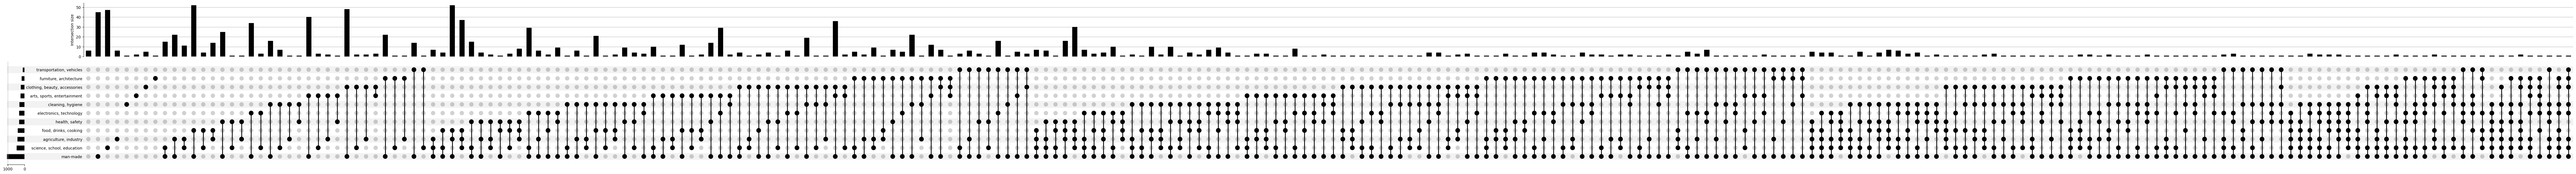

In [10]:
from matplotlib import pyplot as plt
from upsetplot import UpSet, from_memberships

def create_upset_plot(df, figsize=(50, 30)):
    # Step 1: Aggregate duplicate rows
    grouped_df = df.groupby(list(df.columns)).size().reset_index(name='counts')
    
    # Step 2: Create a list of memberships (feature combinations) and their counts
    memberships = []
    counts = []
    for row in grouped_df.itertuples(index=False):
        combination = [col for col, val in zip(grouped_df.columns[:-1], row[:-1]) if val]
        memberships.append(combination)
        counts.append(row.counts)
    
    # Step 3: Convert to UpSet format
    upset_data = from_memberships(memberships, data=counts)
    
    # Step 4: Create and plot the UpSet plot
    plt.figure(figsize = figsize)
    upset = UpSet(upset_data)
    upset.plot()
    plt.show()
    
create_upset_plot(things_df)

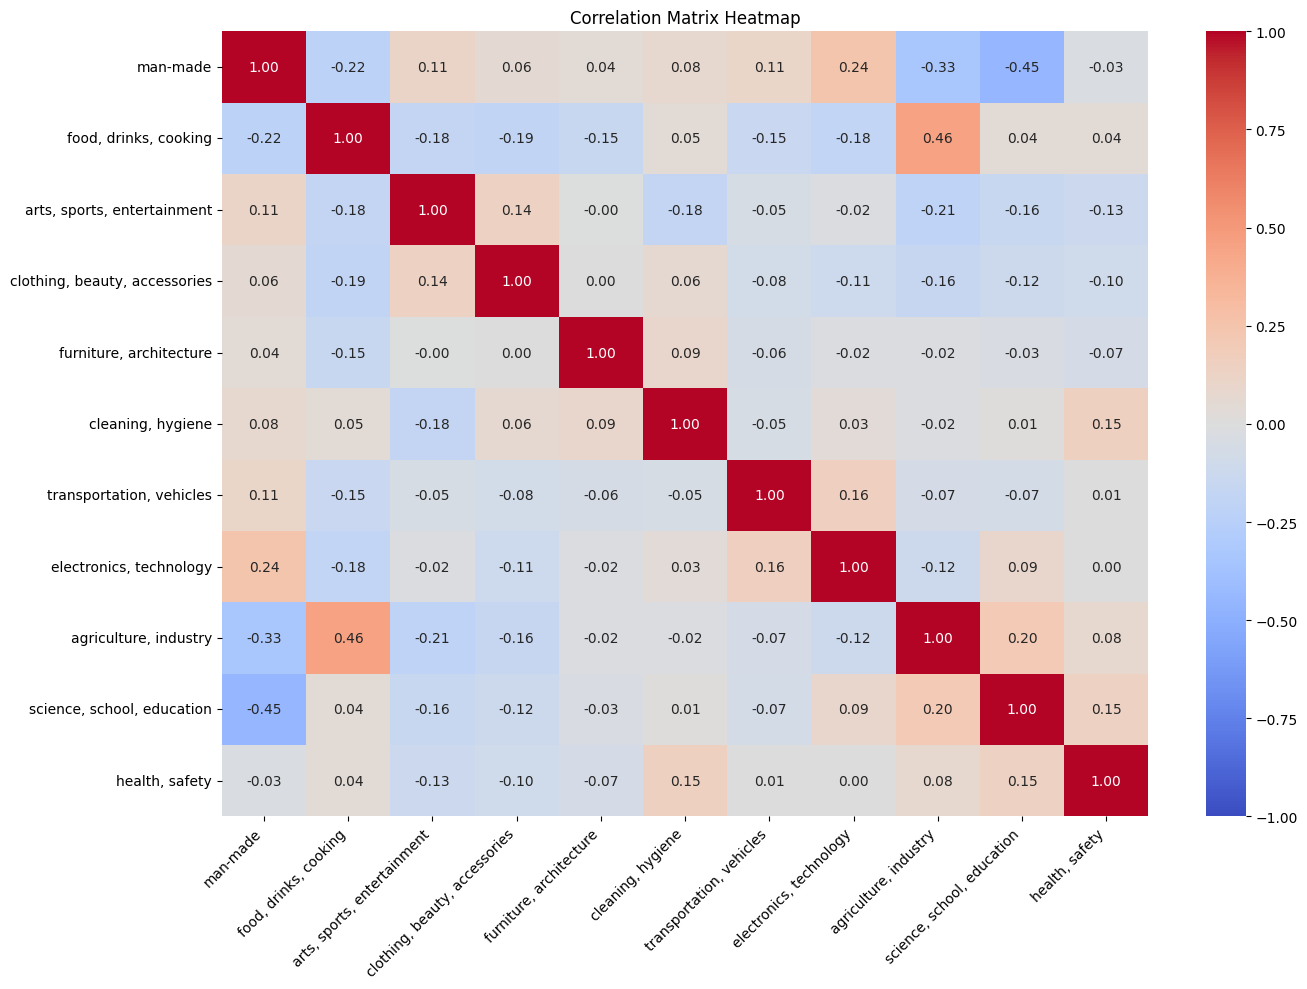

In [11]:
import seaborn as sns

corr_matrix = things_df.corr()

# Step 3: Create a Heatmap of the Correlation Matrix
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, center=0, annot_kws={"size": 10})
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)   # Rotate y-axis labels for better readability
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

## Optimal Game Path with MCTS

In [56]:
import random
import math
import pickle

class MCTNode:
    def __init__(self, state, parent=None):
        self.state = state
        self.parent = parent
        self.children = []
        self.visits = 0
        self.value = 0

    def is_fully_expanded(self, features):
        return len(self.children) == len(features) - len(self.state)

    def best_child(self, c_param=1.4):
        choices_weights = [
            (child.value / child.visits) + c_param * math.sqrt((2 * math.log(self.visits) / child.visits))
            for child in self.children
        ]
        return self.children[np.argmax(choices_weights)]

    def most_visited_child(self):
        visits = [child.visits for child in self.children]
        return self.children[np.argmax(visits)]

    def add_child(self, child_node):
        self.children.append(child_node)

    def use_tree(self, queried_features):
        current_node = self
        for feature, value in queried_features.items():
            for child in current_node.children:
                if child.state.get(feature) == value:
                    current_node = child
                    break
        return current_node

class MCTS:
    def __init__(self, data, features, iterations=1000, min_reduction_percentage=0.1, max_subset_percentage=0.05):
        self.data = data
        self.features = features
        self.iterations = iterations
        self.min_reduction_percentage = min_reduction_percentage
        self.max_subset_percentage = max_subset_percentage
        self.original_size = len(data)
        self.epsilon = 1e-10  # Small value to prevent log(0)

    def search(self, initial_state):
        root = MCTNode(initial_state)

        for _ in tqdm(range(self.iterations), desc="MCTS iterations"):
            node = self.select(root)
            reward = self.simulate(node)
            self.backpropagate(node, reward)

        return root

    def select(self, node):
        while not self.is_terminal(node):
            if not node.is_fully_expanded(self.features):
                return self.expand(node)
            else:
                node = node.best_child()
        return node

    def expand(self, node):
        unqueried_features = [f for f in self.features if f not in node.state]
        feature_to_query = random.choice(unqueried_features)
        new_state = node.state.copy()
        new_state[feature_to_query] = self.query_feature(feature_to_query, new_state)
        child_node = MCTNode(new_state, node)
        node.add_child(child_node)
        return child_node

    def simulate(self, node):
        current_state = node.state.copy()
        unqueried_features = [f for f in self.features if f not in current_state]

        # Select a random row from the DataFrame for this simulation
        random_row = self.data.sample(1).iloc[0]

        while unqueried_features:
            feature_to_query = random.choice(unqueried_features)
            current_state[feature_to_query] = random_row[feature_to_query]
            unqueried_features.remove(feature_to_query)

        return self.evaluate(current_state, len(node.state))

    def backpropagate(self, node, reward):
        while node is not None:
            node.visits += 1
            node.value += reward
            node = node.parent

    def is_terminal(self, node):
        current_subset = self.data.copy()
        for feature, value in node.state.items():
            current_subset = current_subset[current_subset[feature] == value]

        if len(current_subset) <= self.max_subset_percentage * self.original_size:
            return True

        for feature in self.features:
            if feature not in node.state:
                next_subset = current_subset[current_subset[feature] == self.query_feature(feature, node.state)]
                if len(next_subset) / len(current_subset) >= self.min_reduction_percentage:
                    return False

        return True

    def query_feature(self, feature, state, random_row=None):
        if random_row is not None:
            # Use the value from the randomly selected row
            return random_row[feature]
        else:
            current_subset = self.data.copy()
            for f, value in state.items():
                current_subset = current_subset[current_subset[f] == value]
            return current_subset[feature].mode()[0]  # Return the most common value if not simulating

    def evaluate(self, state, n_queries):
        current_subset = self.data.copy()
        for feature, value in state.items():
            current_subset = current_subset[current_subset[feature] == value]
        # Reward is -log(curr_subset_size/original_data_size) / n_queries
        subset_size = len(current_subset)
        return -math.log((subset_size / self.original_size) + self.epsilon) / n_queries if n_queries > 0 else 0

    def save_tree(self, root, filename):
        with open(filename, 'wb') as f:
            pickle.dump(root, f)

    def load_tree(self, filename):
        with open(filename, 'rb') as f:
            return pickle.load(f)

# Function to determine the optimal query order for a given row
def get_optimal_query_order(row, root_node):
    current_node = root_node
    queried_features = {}
    query_order = []

    while len(queried_features) < len(current_node.state) or current_node.children:
        if not current_node.children:
            break  # Exit if a terminal node is reached

        optimal_child = current_node.most_visited_child()
        if not [feature for feature in optimal_child.state if feature not in queried_features]:
            break
        feature_to_query = [feature for feature in optimal_child.state if feature not in queried_features][0]
        query_order.append(feature_to_query)
        queried_features[feature_to_query] = row[feature_to_query]
        current_node = current_node.use_tree({feature_to_query: row[feature_to_query]})

    return query_order


In [14]:
data = things_df
features = things_df.columns.tolist()

In [70]:
mcts = MCTS(data, features, iterations=6500, min_reduction_percentage=0.05, max_subset_percentage=0.03)
initial_state = {}
root_node = mcts.search(initial_state)

MCTS iterations: 100%|██████████| 6500/6500 [02:26<00:00, 44.23it/s]


In [67]:
# Example row to determine the optimal query order
example_row = data.iloc[1010]
print(example_row)
optimal_query_order = get_optimal_query_order(example_row, root_node)
print("Optimal query order for the given row:", optimal_query_order)

man-made                         1
food, drinks, cooking            0
arts, sports, entertainment      0
clothing, beauty, accessories    0
furniture, architecture          1
cleaning, hygiene                0
transportation, vehicles         0
electronics, technology          0
agriculture, industry            0
science, school, education       0
health, safety                   0
Name: shingle, dtype: int64
Optimal query order for the given row: ['science, school, education', 'food, drinks, cooking', 'furniture, architecture']


In [71]:
final_order = []
for index, row in data.iterrows():
    curr_order = get_optimal_query_order(row, root_node)
    if len(curr_order) > len(final_order):
        final_order = curr_order

print(final_order)

['science, school, education', 'transportation, vehicles', 'agriculture, industry', 'furniture, architecture']


## Save as JSONL

In [28]:
def make_list_from_dict(original_dict):
    list_of_dicts = []
    for key, sub_dict in original_dict.items():
        # Create a new dictionary that includes the key from the original dict
        new_dict = {"keyword": key}
        # Update the new dictionary with the key-value pairs from the sub-dictionary
        new_dict.update(sub_dict)
        # Append the new dictionary to the list
        list_of_dicts.append(new_dict)
    return list_of_dicts

labeled_keywords_list = make_list_from_dict(keyword_labels)

In [29]:
with open("20qs-data/labeled_keywords.jsonl", "w") as f:
    for i in labeled_keywords_list:
        json.dump(i, f)
        f.write('\n')

with open("20qs-data/labeling_results.jsonl", "w") as f:
    json.dump(results, f)